In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [197]:
np.random.seed(42)

# Monte Carlo Recepices for Simple Statistics

Heavily based on Jake Vanderplas's talk **Statistics for Hackers**

- https://speakerdeck.com/jakevdp/statistics-for-hackers

Other great resources:

- Jake Vanderplas book: Python Data Science Handbook
- Cam Davidson-Pilon book: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

Main goals:

- to show that even complicated-looking statistics can be simple
- to apply Monte Carlo approach
- to lern to programme a for loop, Python

### The Art of Asking the Right Question

## Coin example

Toss 30 times and get 22 heads. Is the coin fair?

- a fair coin should show about 15 heads!
- even a fair coin could show 22, just by chance, it's random

Classiacl method is to test the Null hypothesis

What is the probability of a fair coin showing 22 heads in 30 tosses by chance?

$P(H) = 1/2$

$P(HH) = (1/2)^2$

$P(2H, 1T) = P(HHT) + P(HTH) + P(THH)$

...

Mr Bernoulli:

$P(N_H, N) = \binom{N}{N_H} p^{N_H} (1 - p)^{N - N_H}$

- number of arrangements
- $p$ probability of head
- probability of $N_H$ heads in $N$ tosses

In [227]:
import scipy.stats

In [228]:
[ n, p ] = [ 30, 0.5 ]
rv = scipy.stats.binom(n, p)
n_h = 22
print rv.pmf(n_h)

0.00545096118003


### The concept of p-value

Probability of obtaining a result equal or more exteme than that what was observed, if the null hypothesis is true.

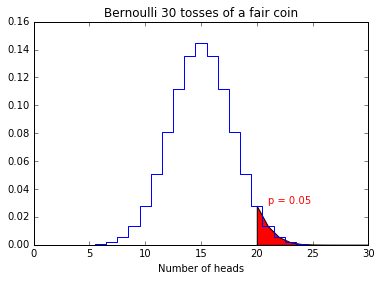

In [229]:
x = np.arange(1, n+1)
v_crit = rv.isf(0.05)

plt.plot(x, rv.pmf(x), linestyle='steps-mid')
plt.fill_between(x[x>v_crit], rv.pmf(x)[x>v_crit], facecolor='red')

#h = plt.vlines(x, 0, rv.pmf(x), lw=2)
#plt.vlines(x[n_h-1:], 0, rv.pmf(x[n_h-1:]), color='red', lw=2)

plt.annotate('p = 0.05',xy=(v_crit+2,0.03),color='red')
plt.title('Bernoulli 30 tosses of a fair coin')
plt.xlabel('Number of heads');

In [230]:
pvalue = scipy.stats.binom_test((22,8), p=p) /2.
# division by 2 because the default is two sided, not one sided
# you can ommit /2 if  alternative='greater' is added
# distribution is symmetric
print pvalue

0.00806240085512


In [231]:
scipy.stats.binom_test(22, 30, 0.5, alternative='greater')

0.0080624008551239933

Probability 0.008 of this observation given a fair coin is smaller than $p < 0.05$. We can reject the fair coin hypothesis at $p = 0.05$ level.

Essential is the knowledge of the shape of the Bernoulli underlying distribution! Interpretation requires understanding the doc/help...

In [232]:
1. - rv.cdf(21)

0.0080624008551239967

In [233]:
# Simulate it!

M = 0
Ntrials = 10000
for i in range(Ntrials):
    trials = np.random.randint(2, size=30)
    if (trials.sum() >= 22):
        M += 1
p = M/np.float(Ntrials)
print p

0.0089


Computing the sampling distribution is often hard, simulating is often easy and intuitive

## Is the difference between two groups of observations significant?

e.g. variability over a period of time

In [245]:
A = np.array([84., 72., 57., 46., 63., 76., 99., 91.])
B = np.array([81., 69., 74., 61., 56, 87., 69., 65., 66., 44., 62., 69.])

NA = len(A)
NB = len(B)

In [246]:
muA, sigA = A.mean(), A.var(ddof=1)
muB, sigB = B.mean(), B.var(ddof=1)
diff = muA-muB
print "Mean A = %.1f"%muA
print "Mean B = %.1f"%muB
print "\nDiff A - B = %.1f\n"%(diff)
print "Sigma A = %.1f"%sigA
print "Sigma B = %.1f"%sigB

Mean A = 73.5
Mean B = 66.9

Diff A - B = 6.6

Sigma A = 316.3
Sigma B = 124.8


Is the difference significant?

But what are the distributions?

Difference of two distributions follows t distribution

Welch's t-test...

$$t = \frac{ \bar{X_1} - \bar{X_2} } {\sqrt{\frac{s^2_1}{n_1} + \frac{s_2^2}{n_2}}}$$

In [250]:
def ttest(mu1, mu2, sig1, sig2, n1, n2):
    return (mu1 - mu2)/np.sqrt(sig1/n1 + sig2/n2)

In [258]:
t = ttest(muA, muB, sigA, sigB, NA, NB)
t

0.93161477717115826

Student t distribution

$$p(t, \nu) = \frac{ \Gamma \left( \frac{\nu + 1}{2}\right) } {\sqrt{\nu \pi} \Gamma \left(\frac{\nu}{2}\right)} \left( 1 + \frac{t^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

where $\nu$ is a degree of freedom...

$$\nu \approx \frac{\left( \frac{s_1^2}{N_1}+ \frac{s^2_2}{N_2}\right)^2}{\frac{s^4_1}{N_1^2(N_1-1)}+ \frac{s^4_2}{N_2^2(N_2 -1)}}$$

and $\Gamma$ is an extension of the factorial function (for integer $n$)
$\Gamma(n) = (n-1)!$ ...


$$\Gamma(t) = \int_0^\infty x^{t-1} \exp(-x) dx$$

<img src="figures/travolta.gif" width="50%">

In [266]:
def degof(s1, n1, s2, n2):
    return (s1/n1 + s2/n2)**2 / (s1**2/(n1**2 * (n1-1)) + s2**2/(n2**2 * (n2-1)) )

In [263]:
( sigA/NA + sigB/NB )**2 / ( ( sigA**2/(NA**2*(NA-1) ) + sigB**2/(NB**2*(NB-1))))

10.696428999751994

But what is the critical value for t-distribution for this $\nu$?

<img src="figures/tstat.png", width="100%">

In [268]:
pval = scipy.stats.t.ppf(0.95, 11)
print pval

1.7958848187


In [93]:
t_crit = 1.7959
t = 0.93
t > t_crit

False

The difference 6.6 is **not** significant at $p=0.05$ level...

In [255]:
print scipy.stats.ttest_ind(A, B, equal_var=False)

Ttest_indResult(statistic=0.93161477717115826, pvalue=0.3720857855465306)


In [265]:
from statsmodels.stats.weightstats import ttest_ind
t, p, dof = ttest_ind(A, B, alternative='larger', usevar='unequal')
print p

0.186042892773


Dark magic lies behind the sampling from t-distribution.

We cannot sample this time, we don't know the underlying distributions of A and B

## Shuffling

Idea: **If the distributions are the same, shuffling (changing labels) will not change the statistics (mean). If the result is the same, the distributions are likely the same**

1. shuffle
2. rearrange
3. compute means and difference

Do 1. - 3. many times. $N > 6.6 / N_tot$. Is it smaller than $p = 0.05$? Reject the hypothesis that shuffling does not matter.

In [279]:
AB = np.concatenate([A, B])
M = 0
N_trials = 10000
for i in range(N_trials):
    np.random.shuffle(AB)
    mu1 = AB[0:NA].mean()
    mu2 = AB[NA:].mean()
    diff = mu1 - mu2
    if (diff > 6.6):
        M = M +1
pvalue = M/np.float(Ntrials)
print pvalue
print pvalue > 0.05 # True if no difference at p= 0.05 level

0.1516
True


Works only if:

- Null hypothesis assumes the two groups follow the same distribution
- samples are representative (be careful about selection biases)
- trials are independent

## Bootstrapping

In [281]:
sample = np.array([48, 24, 51, 12, 21, 41, 25, 23, 32, 61, 19, 24, 29, 21, 23, 13, 32, 18, 42, 18])

What is the mean?

What is the standard error of this mean?

$$\bar{x}=\frac{1}{N}\Sigma_{i=1}^{N} x_i$$

$$\sigma_\bar{x} = \frac{1}{\sqrt{N}}\sqrt{\frac{1}{N-1}}\Sigma_{i=1}^N (x_i - \bar{x})^2$$

In [294]:
sample.mean(), scipy.stats.sem(sample, ddof=1) # standard error of the mean

(28.850000000000001, 2.9702693480558291)

Again, we don't know the model

Bootstrapping:

**Idea: Simulate the distribution by drawing samples from the samples with replacement**

1. draw a sample
2. calculate mean

In [295]:
Ntrials = 10000
xbar = np.empty(10000)

for i in range(Ntrials):
    new_sample = sample[np.random.randint(20, size=20)]
    xbar[i] = np.mean(new_sample)
print xbar.mean(), xbar.std()

28.855995 2.85914074679


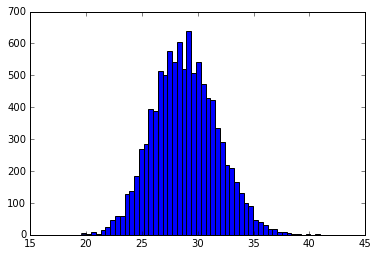

In [296]:
plt.hist(xbar, bins=50);

$29 \pm 3$

Bootstrapping is often used to determine the uncertainity of fit parameters

In [297]:
x = np.array([ 7.5,  8.1,  8.4,  8.8,  8.9,
               9.0,  9.1,  9.2,  9.3,  9.5,
               9.6,  9.9, 10.0, 10.05, 10.5,
              10.6, 10.6, 11.2, 11.8, 12.6 ])
x.size

20

In [298]:
y = np.array([22, 21, 19, 16, 18,
              15, 17, 17, 17, 19,
              14, 14, 15, 11, 12,
              12, 13, 10,  7,  9])
y.size

20

Slope:  -2.96942934494
Intersect: 43.7999710996


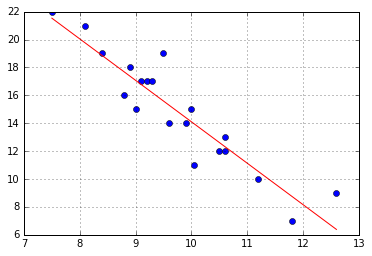

In [299]:
plt.plot(x,y,"o")
plt.grid(True)
slope, intersect = np.polyfit(x,y, 1)
plt.plot(x,slope*x+intersect,'-r')
print "Slope: ", slope
print "Intersect:", intersect

In [300]:
from scipy.stats import linregress
linreg = linregress(x,y)
print "Slope:", linreg.slope
print "Intersect:", linreg.intercept
print "Std Error:", linreg.stderr

Slope: -2.96942934494
Intersect: 43.7999710996
Std Error: 0.289810879821


But this is the error of the fit, what is the error of each parameter?

In [301]:
results = np.empty((10000,2))
for i in range(10000):
    ind = np.random.randint(20, size=20)
    slope, intercept = np.polyfit(x[ind],y[ind], 1)
    results[i][0], results[i][1] = slope, intercept

In [302]:
results[:,0].mean(), results[:,0].std()

(-3.0037107271184298, 0.32373109656383681)

In [303]:
results[:,1].mean(), results[:,1].std()

(44.107504456403923, 3.0854143593880985)

- Bootstrapping does not work for only few samples (N<20)
- Be careful about biases

## Cross validation

We know this from ML already

which model is a better fit?

$y = a + b x$

$y = a + b x + c x^2$

or higher polynomial?

- measure of error is rms (root of sum of squared errors)
- but more flexible models will always have lower RMS error

difference in mean squared error follows chi-square distribution

$$p(x, \nu) = \frac{1}{2^{\nu/2}\Gamma \left(\frac{\nu}{2}\right)} x ^{\frac{\nu}{2}-1} \exp \left({-\frac{1}{2}x}\right)$$

$\nu \approx \nu_2 - \nu_1$

$\nu_2 \approx (N - d_2)$

$\nu_1 \approx (N - d_1)$

models are nested, therefore one can estimate degrees of freedom easily

In [507]:
import numpy as np

np.random.seed(0)
true_fun = lambda X: 10 - 1. / (X + 0.1)

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
#    rng = np.random.RandomState(rseed)
    X = np.sort(np.random.rand(N))
    X = X[:, np.newaxis]
    #X = np.sort(rng.rand(N, 1))
    y = true_fun(X.ravel())
    if err > 0:
        y += err * 1.*np.random.randn(N)
    return X, y

N = 30
X, y = make_data(N)

In [508]:
def rms(y_real, y_predicted):
    return np.sqrt(np.mean( (y_real-y_predicted)**2) )

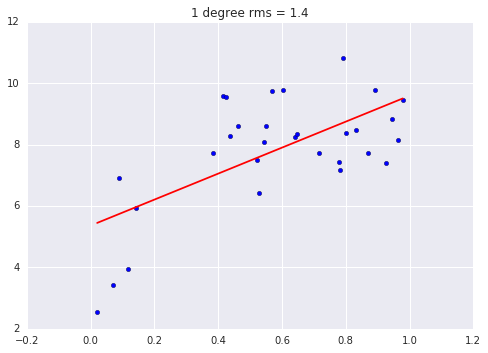

In [509]:
z1 = np.polyfit(X.ravel(), y, 1)
f1 = np.poly1d(z1)
y_new = f1(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')
plt.title('1 degree rms = %.1f'%rms(y, y_new))

In [510]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms1 = sqrt(mean_squared_error(y, y_new))
rms1

1.4167738123934264

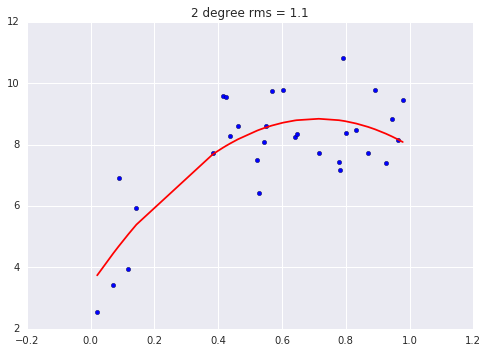

In [511]:
z2 = np.polyfit(X.ravel(), y, 2)
f2 = np.poly1d(z2)
y_new = f2(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')
plt.title('2 degree rms = %.1f'%rms(y, y_new))

In [512]:
rms2 = sqrt(mean_squared_error(y, y_new))
rms2

1.134207969060934

Cross-validation idea:

1. Split data **randomly** in two sets
2. Fit both halves
3. Use the model and calculate the rms for the other half and vice versa
4. Compare rms and cross-validated rms

In [513]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

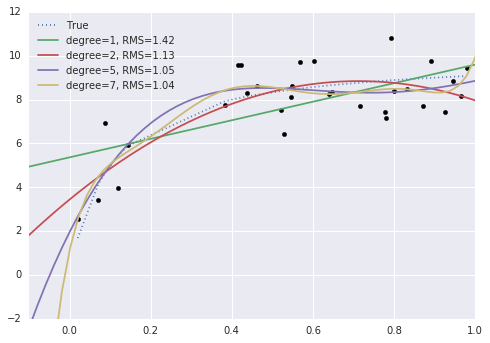

In [514]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 2*N)[:, None]

plt.scatter(X.ravel(), y, color='black')
plt.plot(X.ravel(), true_fun(X.ravel()), label='True', linestyle=":")

axis = plt.axis()
for degree in [1, 2, 5, 7]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    y_fool = PolynomialRegression(degree).fit(X, y).predict(X)
    rms_val = rms(y, y_fool)
#    scores = cross_validation.cross_val_score(PolynomialRegression(degree),
#        X, y, scoring="mean_squared_error", cv=cv)
    plt.plot(X_test.ravel(), y_test, label='degree={0}, RMS={1:.2f}'.format(degree, rms_val))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

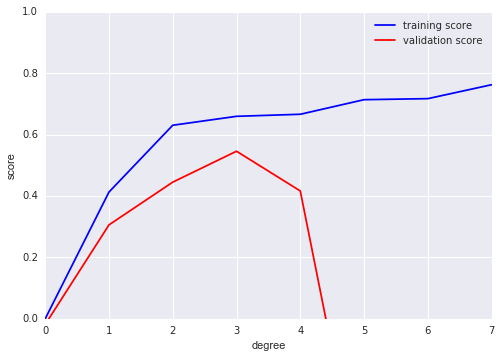

In [515]:
from sklearn.cross_validation import KFold
from sklearn import cross_validation

cv = KFold(N, n_folds=2, shuffle=True, random_state=1)


from sklearn.learning_curve import validation_curve
degree = np.arange(0, 8)
    
train_score, val_score = validation_curve(PolynomialRegression(),
                                          X, y,
                                          'polynomialfeatures__degree',
                                          degree,
                                          cv=cv)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Cross validation is often the only choice in machine learning, because the statistics of the models are typically not known.

## Monte Carlo Markov Chain Fitting